### Step1. 필요한 라이브러리들을 import 합니다.

In [1]:
import pandas as pd
import numpy as np
import tensorflow

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation # core layers
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

### STEP2. 데이터셋을 설정

In [2]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
sub = pd.read_csv('./input/sample_submission.csv')
print("Data are Ready!!")
print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")

Data are Ready!!
Training data size is (42000, 785)
Testing data size is (28000, 784)


레이블링 세팅

In [3]:
X = train.drop(['label'], 1).values
y = train['label'].values


/var/folders/v3/ybc9hrrd0yg6d_zr2sbckrtm0000gn/T/ipykernel_6435/368830679.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = train.drop(['label'], 1).values


Nomalization

In [4]:
X = X / 255.0

Reshape, 주의 ! 위의 두 셀은 딱 한번씩만

In [5]:
X = X.reshape(-1,28,28,1)

One-hot 인코딩

In [6]:
y = to_categorical(y)

print(f"Label size {y.shape}")

Label size (42000, 10)


학습 데이터 분리

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

샘플 데이터 몇개를 시각화

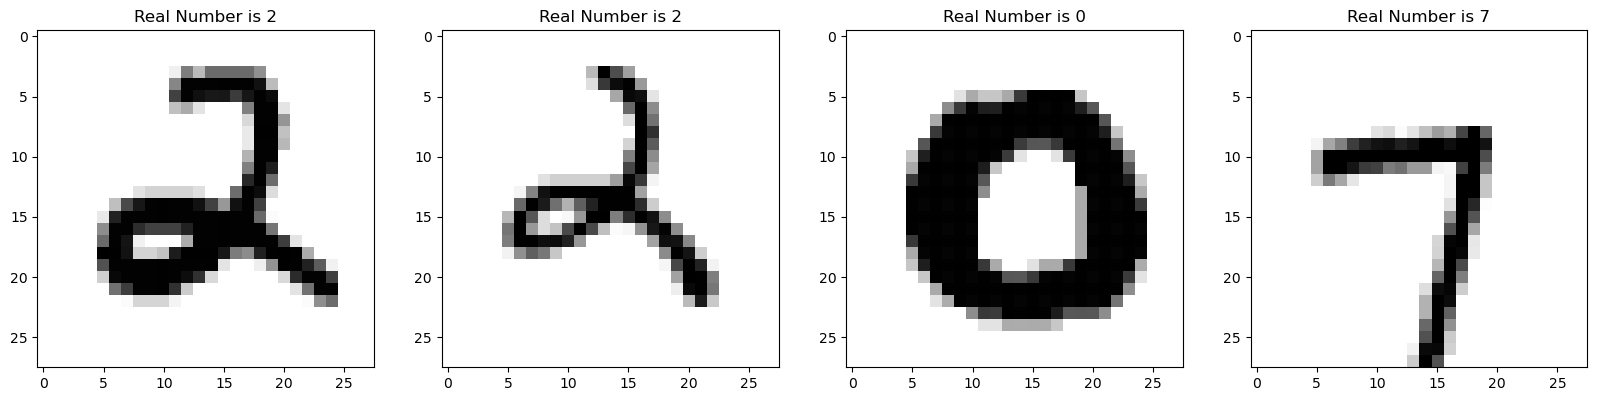

In [8]:
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

### STEP3. CNN모델 만들기

In [9]:
# def random_multiplier(shape):
#     return tensorflow.random.uniform(shape, minval=0.99, maxval=1.01)

# class RandomMultiplierLayer(tensorflow.keras.layers.Layer):
#     def call(self, inputs):
#         random_factors = random_multiplier(inputs.shape[1:])
#         return inputs * random_factors
    
def random_multiplier(shape):
    random_factors = np.random.choice([1.01, 0.99], size=shape, p=[0.5, 0.5])
    return random_factors

class RandomMultiplierLayer(tensorflow.keras.layers.Layer):
    def call(self, inputs):
        random_factors = random_multiplier(inputs.shape[-1])
        return inputs * random_factors

model=Sequential()

model.add(Conv2D(filters=64, kernel_size = (3,3), input_shape=(28,28,1)))
model.add(RandomMultiplierLayer())
model.add(Activation('relu'))
model.add(RandomMultiplierLayer())
model.add(Conv2D(filters=64, kernel_size = (3,3)))
model.add(RandomMultiplierLayer())
model.add(Activation('relu'))
model.add(RandomMultiplierLayer())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(RandomMultiplierLayer())
model.add(BatchNormalization())
model.add(RandomMultiplierLayer())

model.add(Conv2D(filters=128, kernel_size = (3,3)))
model.add(RandomMultiplierLayer())
model.add(Activation('relu'))
model.add(RandomMultiplierLayer())


model.add(Conv2D(filters=128, kernel_size = (3,3)))
model.add(RandomMultiplierLayer())
model.add(Activation('relu'))
model.add(RandomMultiplierLayer())


model.add(MaxPooling2D(pool_size=(2,2)))
model.add(RandomMultiplierLayer())
model.add(BatchNormalization())    
model.add(RandomMultiplierLayer())

model.add(Conv2D(filters=256, kernel_size = (3,3)))
model.add(RandomMultiplierLayer())
model.add(Activation('relu'))
model.add(RandomMultiplierLayer())

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(RandomMultiplierLayer())
model.add(BatchNormalization())
model.add(RandomMultiplierLayer())
    
model.add(Flatten())
model.add(RandomMultiplierLayer())
model.add(Dense(512))
model.add(RandomMultiplierLayer())
model.add(Activation('relu'))
model.add(RandomMultiplierLayer())

    
model.add(Dense(10))
model.add(RandomMultiplierLayer())
model.add(Activation('softmax'))
model.add(RandomMultiplierLayer())

    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

2023-08-10 22:55:36.636168: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-10 22:55:36.636304: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



모델 요약

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 random_multiplier_layer (Ra  (None, 26, 26, 64)       0         
 ndomMultiplierLayer)                                            
                                                                 
 activation (Activation)     (None, 26, 26, 64)        0         
                                                                 
 random_multiplier_layer_1 (  (None, 26, 26, 64)       0         
 RandomMultiplierLayer)                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 random_multiplier_layer_2 (  (None, 24, 24, 64)       0

데이터 증강

In [11]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=512)
test_gen = datagen.flow(X_test, y_test, batch_size=512)

학습 세부 설정

In [12]:
epochs = 10
batch_size = 512
train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size

es = tensorflow.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = tensorflow.keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

모델의 학습 진행

In [13]:
history = model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks=[es, rp])

Epoch 1/10


/var/folders/v3/ybc9hrrd0yg6d_zr2sbckrtm0000gn/T/ipykernel_6435/3085895664.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,
2023-08-10 22:55:45.366082: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-10 22:55:46.070827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


73/73 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9281

2023-08-10 22:56:06.263002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


73/73 [==============================] - 22s 284ms/step - loss: 0.2238 - accuracy: 0.9281 - val_loss: 2.2478 - val_accuracy: 0.0964 - lr: 0.0010
Epoch 2/10
73/73 [==============================] - 20s 276ms/step - loss: 0.0568 - accuracy: 0.9821 - val_loss: 2.4506 - val_accuracy: 0.2598 - lr: 0.0010
Epoch 3/10
73/73 [==============================] - 21s 292ms/step - loss: 0.0424 - accuracy: 0.9860 - val_loss: 3.1177 - val_accuracy: 0.2310 - lr: 0.0010
Epoch 4/10
73/73 [==============================] - 21s 288ms/step - loss: 0.0355 - accuracy: 0.9888 - val_loss: 2.2517 - val_accuracy: 0.3713 - lr: 0.0010
Epoch 5/10
73/73 [==============================] - 22s 304ms/step - loss: 0.0319 - accuracy: 0.9897 - val_loss: 1.0392 - val_accuracy: 0.6611 - lr: 0.0010
Epoch 6/10
73/73 [==============================] - 21s 281ms/step - loss: 0.0296 - accuracy: 0.9911 - val_loss: 0.4176 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 7/10
73/73 [==============================] - 21s 283ms/step - loss: 

학습 결과 요약 -> 개쩜 굳.

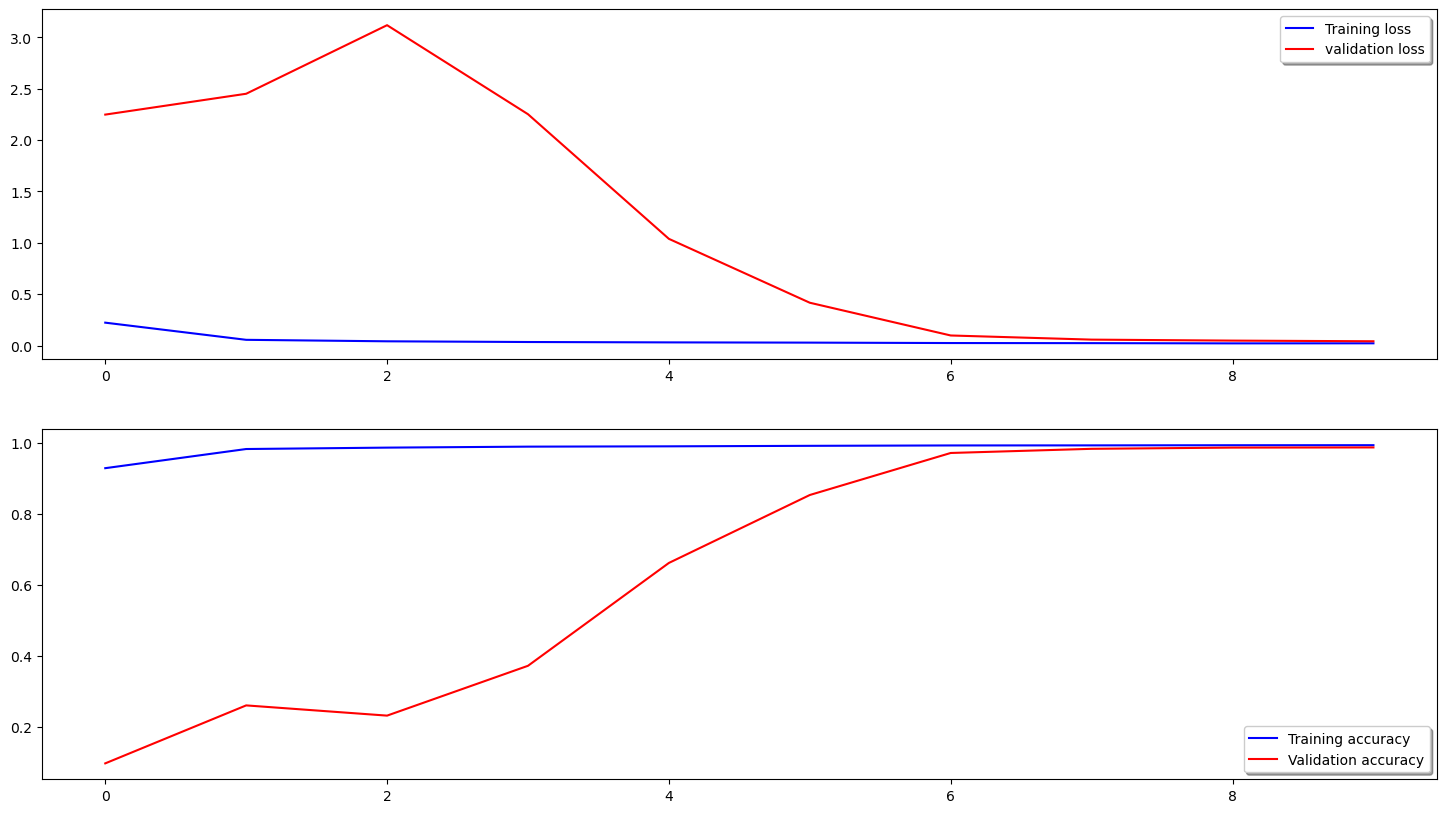

In [14]:
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Confusion Matrix 그리기. 대각선이 정답.

  1/132 [..............................] - ETA: 35s

2023-08-10 22:59:24.668366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 1s 8ms/step


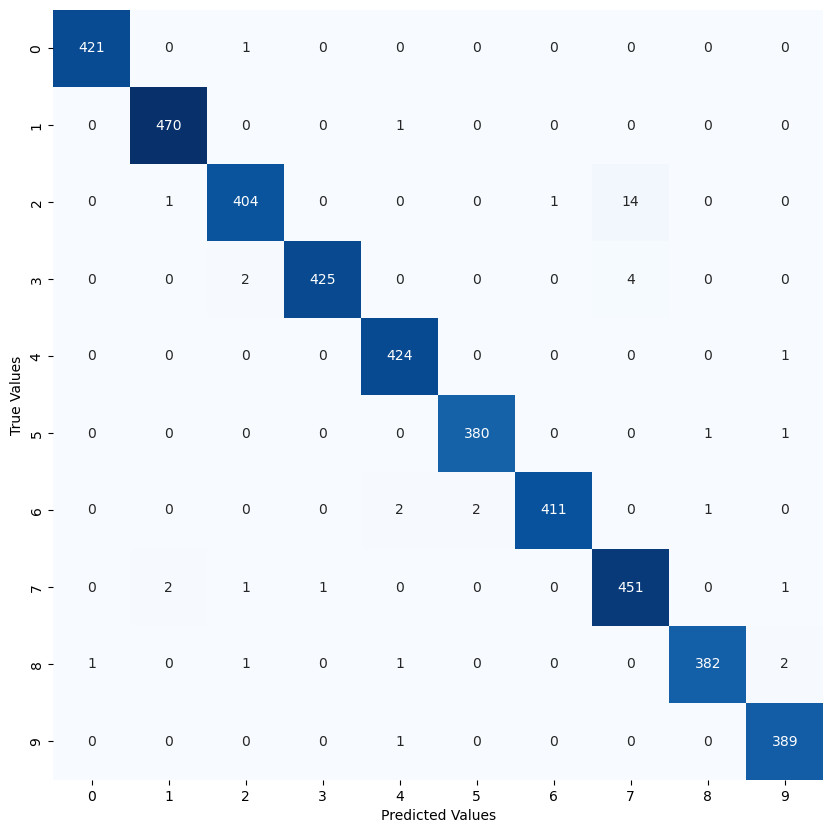

In [15]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

In [16]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_accuracy} Test loss: {test_loss}")

132/132 - 1s - loss: 0.0313 - accuracy: 0.9902 - 1s/epoch - 10ms/step
Test accuracy: 0.9902380704879761 Test loss: 0.03133058547973633


### FINAL. 모델을 저장하기.

In [17]:
model.save('my_model_1.h5')